# 1. 모듈 임포트 하기

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn

# 2. 데이터셋 구성하기

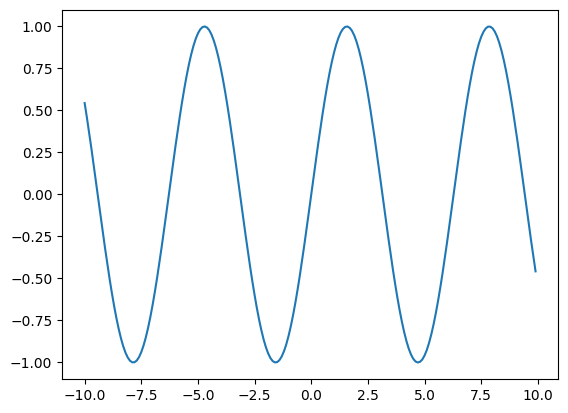

In [ ]:
# 학습데이터
x = [ i for i in np.arange(start=-10, stop=10, step=0.1)]
train_y = [ np.sin(i) for i in x ]
plt.plot(x, train_y)

In [ ]:
# 학습 데이터를 입력데이터와 정답 데이터로 분리하는 함수
def split_sequence(sequence, step):
  x, y = list(), list()
  for i in range(len(sequence)):
    end_idx = i + step
    if end_idx > len(sequence) - 1:
      break
    seq_x, seq_y = sequence[i:end_idx], sequence[end_idx]
    x.append(seq_x)
    y.append(seq_y)

  return np.array(x), np.array(y)

In [ ]:
# 입력 데이터 크기 15x1
n_timesteps = 15
n_features = 1

#데이터셋 구성
train_x, train_y = split_sequence(train_y, step = n_timesteps)
train_x.shape, train_y.shape

((185, 15), (185,))

In [ ]:
train_x[0], train_y[0]

(array([ 0.54402111,  0.45753589,  0.36647913,  0.27176063,  0.17432678,
         0.07515112, -0.02477543, -0.12445442, -0.22288991, -0.31909836,
        -0.41211849, -0.50102086, -0.58491719, -0.66296923, -0.7343971 ]),
 -0.798487112623487)

In [ ]:
train_x[1], train_y[1]

(array([ 0.45753589,  0.36647913,  0.27176063,  0.17432678,  0.07515112,
        -0.02477543, -0.12445442, -0.22288991, -0.31909836, -0.41211849,
        -0.50102086, -0.58491719, -0.66296923, -0.7343971 , -0.79848711]),
 -0.8545989080882778)

In [ ]:
train_x.shape

(185, 15)

In [ ]:
# RNN 입력 [batch_size, timesteps, feature]
train_x = train_x.reshape(train_x.shape[0], train_x.shape[1], n_features)

In [ ]:
train_x.shape, train_y.shape

((185, 15, 1), (185,))

In [ ]:
import torch
from torch.utils.data import DataLoader, TensorDataset

dataset = TensorDataset(torch.Tensor(train_x), torch.Tensor(train_y))
batch_size = 1
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [ ]:
for batch_x, batch_y in dataloader:
    print(batch_x.shape, batch_y.shape)
    break

torch.Size([1, 15, 1]) torch.Size([1])


# 3. 모델 설계

In [ ]:
hidden_size = 8
input_size = 1

class RNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.rnn =nn.RNN(input_size=input_size, hidden_size=hidden_size, batch_first=True)
        self.fc = nn.Linear(in_features=120, out_features=1)

    def forward(self, x, h0):
        x, hn = self.rnn(x, h0)
        x = torch.reshape(x, (x.shape[0], -1))

        x = self.fc(x)
        x = torch.flatten(x)
        return x

rnn = RNN()

# 4. 모델 학습

In [ ]:
import torch.nn as nn
import torch.optim as optim

criterion = nn.MSELoss()  # 평균 제곱 오차
optimizer = optim.Adam(rnn.parameters(), lr=0.001)  # 확률적 경사 하강법

h0 = torch.zeros( input_size, batch_size, hidden_size)
# 학습 루프
num_epochs = 100
for epoch in range(num_epochs):
    total_loss = 0.0
    for batch_x, batch_y in dataloader:
        optimizer.zero_grad()  # 기울기 초기화

        # 순방향 전파
        outputs = rnn(batch_x, h0)
        # 손실 계산
        loss = criterion(outputs, batch_y)  # 배치 내 손실 계산

        # 역전파 및 가중치 업데이트
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    average_loss = total_loss / len(dataloader)
    print(f'Epoch [{epoch + 1}/{num_epochs}], Average Loss: {average_loss:.10f}')
torch.save(rnn.state_dict(), "rnn.pth")

# 5. 모델 성능 평가

array([-0.54402111, -0.62507065, -0.69987469, -0.76768581, -0.82782647,
       -0.87969576, -0.92277542, -0.95663502, -0.98093623, -0.99543625,
       -0.99999021, -0.99455259, -0.97917773, -0.95401925, -0.91932853])

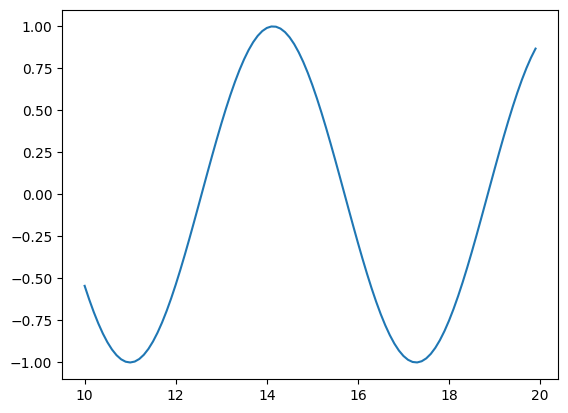

In [ ]:
x = np.arange(10,20,0.1)
calc_y = np.sin(x)
plt.plot(x, calc_y)

# 입력 데이터 크기 15x1
n_timesteps = 15
n_features = 1

#데이터셋 구성
test_y = calc_y[:n_timesteps]
test_y

In [ ]:
#성능 평가 방법 1
x = np.arange(10,20,0.1)
calc_y = np.sin(x)
# 입력 데이터 크기 15x1
n_timesteps = 15
n_features = 1

#데이터셋 구성
test_y = calc_y[:n_timesteps]

preds = []
total_loss = 0

with torch.no_grad():
    rnn.load_state_dict(torch.load("rnn.pth"))
    for i in range(len(x)-n_timesteps):
        net_input = test_y[i:i+n_timesteps]
        net_input = torch.Tensor(net_input.reshape(1, n_timesteps, n_features))
        predict_y = rnn(net_input,h0)
        test_y = np.append(test_y, predict_y)

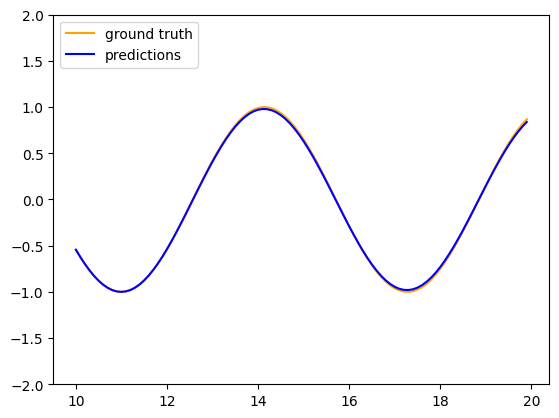

In [ ]:
import matplotlib.pyplot as plt

plt.plot(x, calc_y, label="ground truth", color="orange")
plt.plot(x, test_y, label="predictions", color="blue")
plt.legend(loc="upper left")
plt.ylim(-2,2)
plt.show()

In [ ]:
#성능 평가 방법 2
#데이터셋 구성
x = np.arange(10,20,0.1)
calc_y = np.sin(x)
test_x, test_y = split_sequence(calc_y, step = n_timesteps)
test_x.shape, test_y.shape
# RNN 입력 [batch_size, timesteps, feature]
test_x = test_x.reshape(test_x.shape[0], test_x.shape[1], n_features)
test_dataset = TensorDataset(torch.Tensor(test_x), torch.Tensor(test_y))
batch_size = 1
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
for batch_x, batch_y in test_dataloader:
    print(batch_x.shape, batch_y.shape)
    break

preds2 = []
with torch.no_grad():
    rnn.load_state_dict(torch.load("rnn.pth"))
    for batch_x, batch_y in test_dataloader:
        pred = rnn(batch_x,h0)
        preds2.append(pred.item())


torch.Size([1, 15, 1]) torch.Size([1])


/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  ary = asanyarray(ary)
/usr/local/lib/python3.10/dist-packages/numpy/core/shape_base.py:65: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ary = asanyarray(ary)


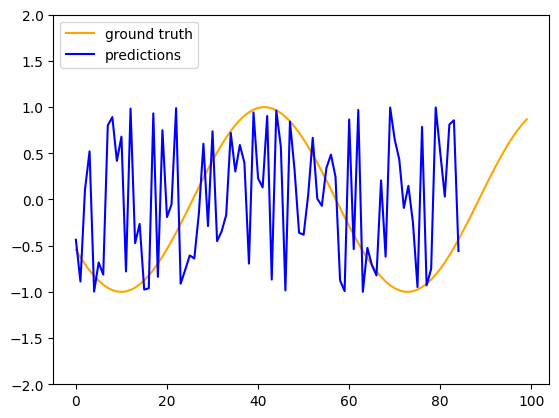

In [ ]:
import matplotlib.pyplot as plt

plt.plot(calc_y, label="ground truth", color="orange")
plt.plot(preds2, label="predictions", color="blue")
plt.legend(loc="upper left")
plt.ylim(-2,2)
plt.show()

# 예제 2

(21, 1)
(20, 1)
(20, 1)


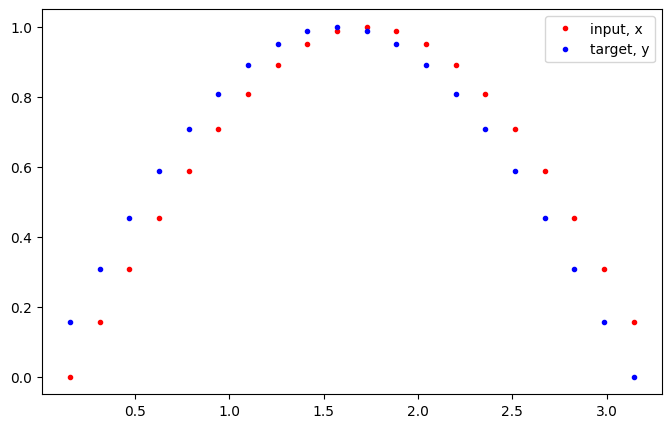

In [ ]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize=(8,5))
seq_length = 20

time_steps = np.linspace(0, np.pi, seq_length+1)#start, stop, num
data = np.sin(time_steps)
data.resize((seq_length + 1,1))
x = data[:-1]
y = data[1:]
print(data.shape)
print(x.shape)
print(y.shape)

plt.plot(time_steps[1:],x,'r.',label='input, x')
plt.plot(time_steps[1:],y,'b.',label='target, y')
plt.legend(loc='best')
plt.show()

In [ ]:
class RNN(nn.Module):

    def __init__(self, input_size,output_size, hidden_dim, n_layers):
        super(RNN,self).__init__()
        self.hidden_dim = hidden_dim # RNN의 Hidden layer 차원
        self.rnn = nn.RNN(input_size, hidden_dim, n_layers, batch_first=True)
    	# batch_first - 처음 들어오는 배치의 크기에 맞추는 것
        self.fc = nn.Linear(in_features=32, out_features=1)

    def forward(self,x, hidden):
        batch_size = x.size(0)
        r_out,hidden = self.rnn(x, hidden)
        r_out = r_out.view(-1,self.hidden_dim)
        output=self.fc(r_out)

        return output,hidden

In [ ]:
# 하이퍼 파라메터
input_size = 1
output_size = 1
hidden_dim = 32
n_layers = 1

# instance
rnn = RNN(input_size, output_size, hidden_dim,n_layers)
print(rnn)

RNN(
  (rnn): RNN(1, 32, batch_first=True)
  (fc): Linear(in_features=32, out_features=1, bias=True)
)


In [ ]:
#손실함수와 최적화
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(rnn.parameters(), lr=0.01)

def train(rnn, n_steps, print_every):
    hidden = None
    for batch_i ,step in enumerate(range(n_steps)):
        time_steps = np.linspace(step*np.pi, (step+1)*np.pi, seq_length+1)
        data = np.sin(time_steps)
        data.resize((seq_length+1,1))

        x = data[:-1]
        y = data[1:]

        x_tensor = torch.Tensor(x).unsqueeze(0)
        y_tensor=torch.Tensor(y)

        prediction, hidden = rnn(x_tensor, hidden)
        hidden = hidden.data

        loss = criterion(prediction, y_tensor)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_i % print_every==0:
            print('Loss : ', loss.item())
            plt.plot(time_steps[1:],x,'r.')
            plt.plot(time_steps[1:], prediction.data.numpy().flatten(),'b.')
            plt.show()

    return rnn

Loss :  0.39503365755081177


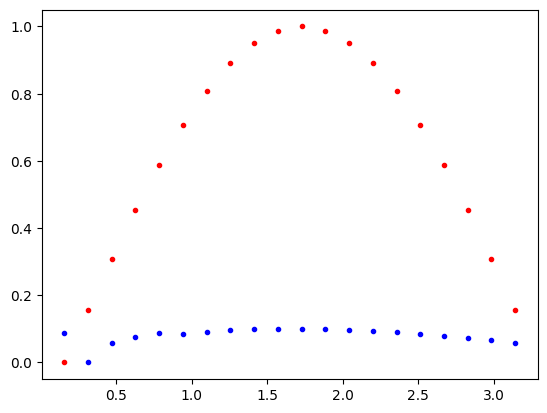

Loss :  0.035284411162137985


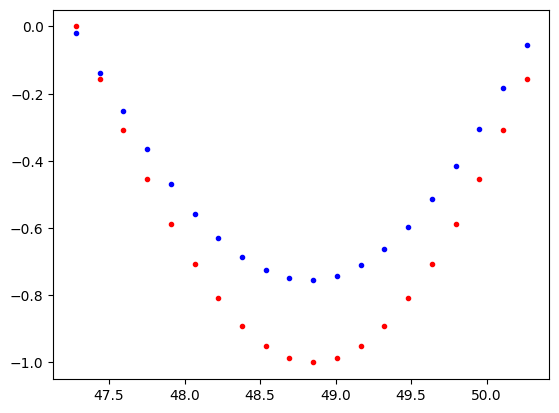

Loss :  0.003437975887209177


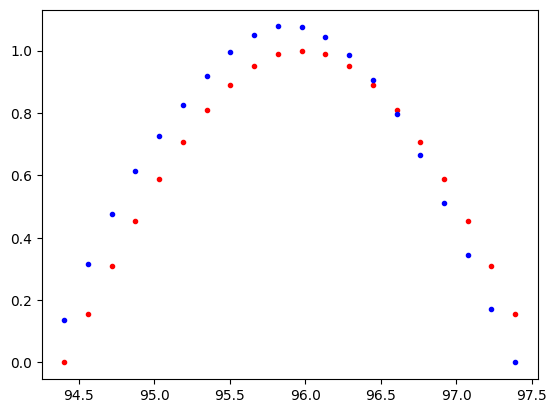

Loss :  0.0009446906624361873


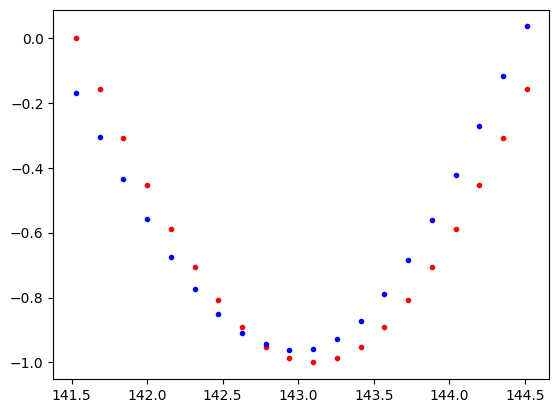

Loss :  0.0001761042367434129


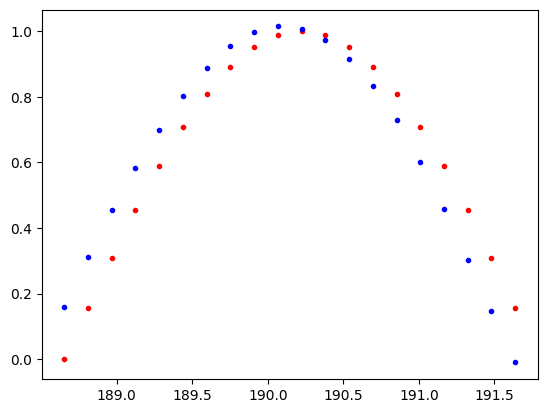

In [ ]:
n_steps = 75
print_every = 15

trained_rnn = train(rnn, n_steps, print_every)